<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../../../Index.ipynb" target="_blank"><< Index</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Vinca Rosmorduc (CLS), Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fapplications%2Focean-case-studies/HEAD?urlpath=%2Ftree%2FCase_studies%2FThematic%2FAltimetry_swh_topography%2FLinking_land_topography_with_altimetry_swh.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>
<br><br>

<div class="alert alert-block alert-success">
<h3>Ocean case studies</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download data from the EUMETSAT Data Store
    
There are no prerequisite notebooks for this module, but you may wish to look at the following notebooks on using SRAL data; <br>
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-SRAL" target="_blank">Learn SRAL (EUMETSAT Gitlab)</a>**
</div>
<hr>

# Altimetry derived significant wave height during a major North Atlantic winter storm

### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SRAL level-2 | EO:EUM:DAT:0415 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___NTC?query=SRAL&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SR_2_WAT___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASR_2_WAT___" target="_blank">link</a>|

### Learning outcomes

At the end of this notebook you will know;
* how to download data from the EUMETSAT Data Store using the <font color="#138D75">**eumetsat data access (eumdac)**</font> client
* how to plot altimetry derived winds and significant wave height in context with coastal topography
* how to compare altimetry products with data from other sources, such as Sentinel-1

### Outline

Three storms hit western Europe end of October-beginning of November 2023, called Céline, Ciaran, Domingos. Noticeable SWH were recorded during those, especially during Domingos. We'll have a look using Sentinel-3A & B data.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Downloading altimetry products from the EUMETSAT Data Store API](#section1)
 1. [Plot altimetry derived significant wave height and winds](#section2)
 1. [Comparing with Sentinel-1 SAR wind data](#section3)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../../../README.md" target="_blank">README</a>**.

In [1]:
import os                              # a library that allows us access to basic operating system commands
import glob
import json                            # a library that helps us make JSON format files
import eumdac                          # a tool that helps us download via the eumetsat/data-store
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import zipfile                         # a library that support zipping/unzipping files
import xarray                          # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import cartopy                         # a library that supports mapping and projection
import cartopy.crs as ccrs             # a library that supports mapping and projection
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"

We will also set the default font size for our plots.

In [2]:
plt.rcParams.update({'font.size': 16})

<hr>
<div class="alert alert-info" role="alert">

## 1. <a id='section1'></a>Downloading altimetry products from the EUMETSAT Data Store API
[Back to top](#TOC-TOP)

</div>

We are going to study an area west of France and Ireland. 

In this section of the notebook we will select and acquire some Sentinel-3 SAR Radar Altimeter (SRAL) that is relevant to our region of interest (ROI). Lets begin by defining the bounds of this region, converting them into a well known text (WKT) format polygon that describes the list of the corners of a box.

Sentinel-6, Jason-3 could also be used, with slightly different variables, with also several products to download to have both SWH and waveforms.

Along with this, we will also define our time range of interest (we'll be looking only over a day on the period when Domingos blew).

In [34]:
# defining our bounding box
lon_min = -30
lon_max = 0
lat_min = 40
lat_max = 55

# make a WKT polygon string for this box
roi = [[lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min], [lon_min, lat_min], [lon_min, lat_max]]
polygon = 'POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi]))

# defining out search times;
start = datetime.datetime(2023, 11, 4, 0, 0)
end = datetime.datetime(2023, 11, 4, 23, 59)

Next we will define directory to download our SRAL products into. By default we will set this to a directory called "products" that is in the same folder as this notebook.

In [4]:
# Create a download directory for our products
#download_dir = os.path.join(os.getcwd(), "products")
download_dir = "products/"
os.makedirs(download_dir, exist_ok=True)

Now lets retrieve our products from the EUMETSAT Data Store.

To access Sentinel-3 & 6 data from the **<a href="https://data.eumetsat.int">EUMETSAT Data Store</a>**, we will use the EUMETSAT Data Access Client (`eumdac`). If you are working with the recommended Anaconda Python distribution and used the supplied environment file (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

However, you can also find the source code on the **<a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac">EUMETSAT gitlab</a>**. Please visit the EUMETSAT user support confluence spaces for the the **<a href="https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview">Data Store</a>** and **<a href="https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/overview">eumdac</a>** for more information.

In order to allow us to download data from the Data Store via API, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumdac_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

<div class="alert alert-block alert-success">

#### Option 1: creating  `.eumdac_credentials` in your home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"consumer_key": "<your_consumer_key>",
"consumer_secret": "<your_consumer_secret>"
}
```

You must replace `<your_consumer_key>` and `<your_consumer_secret>` with the information you extract from **https://api.eumetsat.int/api-key/**. You will need an **<a href="https://eoportal.eumetsat.int/">EUMETSAT Earth Observation Portal account</a>** to access this link, and in order to see the information you must click the "Show hidden fields" button at the bottom of the page.

*Note: your key and secret are permanent, so you only need to do this once, but you should take care to never share them*

Make sure to save the file without any kind of extension. Once you have done this, you can read in your credentials using the commands in the following cell with `file_credentials = True`. These credentials will be used to generate a time-limited token, which will refresh itself when it expires.
    
</div>
    
<div class="alert alert-danger" role="alert">

#### Option 2: Generating a token directly by entering your key and secret in the notebook as follows*
   
Alternatively you can enter your credentials directly in the notebook by updating the following line with your user specifi information and setting `file_credentials = False`.

```
token = eumdac.AccessToken(("consumer_key", "consumer_secret"))
```

However, while this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.
    
</div>
    
*Note: In the near future you will also be able to use this method for Sentinel-6 operational products.*

Let's now use `eumdac` to get an access token that will allows us to download products.

In [5]:
# load credentials
file_credentials = True

if file_credentials == True:
    with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
        credentials = json.load(json_file)
        token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
        print(f"This token '{token}' expires {token.expiration}")
else:
    # see below for more information
    token = eumdac.AccessToken(("consumer_key", "consumer_secret"))

This token '57a0b6d9-9c0d-3a4a-89e9-69b2efe17e70' expires 2024-03-06 11:37:25.272545


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [6]:
datastore = eumdac.DataStore(token)

Data in the Data Store are stored as collections, each with its own ID. If we don't know our collection ID *a priori*, we can find this information via the **<a href="https://data.eumetsat.int/">Data Store GUI</a>** or by asking `eumdac` to tell us about all available SRAL and Poseidon-4 collections as follows:

In [7]:
#list all SRAL and Poseidon-4 collection IDs - if we don't know a priori which satellite we are interested in. 
for collection_id in datastore.collections:
    if ("SRAL" in collection_id.title) or ("Poseidon-4" in collection_id.title):
        if "non-public" in collection_id.abstract: continue
        print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0237): Poseidon-4 Altimetry Level 1B Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0855): Poseidon-4 Altimetry Level 2 High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0857): Poseidon-4 Altimetry Level 2P Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0584): SRAL Level 1B (version BC004) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0836): SRAL Level 1A Unpacked L0 Complex Echoes (version BC005) - Sentinel-3 - Reprocessed
Collection ID(EO:EUM:DAT:0239): Poseidon-4 Altimetry Level 2 Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0406): SRAL Level 1B - Sentinel-3
Collection ID(EO:EUM:DAT:0413): SRAL Level 1A Unpacked L0 Complex echos - Sentinel-3
Collection ID(EO:EUM:DAT:0415): SRAL Level 2 Altimetry Global - Sentinel-3
Collection ID(EO:EUM:DAT:0851): Poseidon-4 Altimetry Level 1B High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0833): SRAL Level 1B (versi

From the lists above, we will pick the "SRAL Level 2 Altimetry Global - Sentinel-3" collection ID (`EO:EUM:DAT:0415`). Note that it includes both Sentinel-3A & Sentinel-3B, and this at NRT, STC and NTC delays.

Note that, depending on the period you're interested in, only operational or only reprocessed data may be available. 

Lets now get out collection....

In [8]:
collectionID = 'EO:EUM:DAT:0415'
selected_collection = datastore.get_collection(collectionID)

Now we have our collection of interest, we can refine our search to obtain **only** the products that match our criteria. Lets apply our search and list our results.

In [9]:
products = selected_collection.search(geo=polygon, dtstart=start, dtend=end)

for product in products:
    print(product)

S3B_SR_2_WAT____20231104T222825_20231104T231345_20231130T140830_2720_086_029______MAR_O_NT_005.SEN3
S3A_SR_2_WAT____20231104T212622_20231104T221139_20231130T130007_2717_105_171______MAR_O_NT_005.SEN3
S3B_SR_2_WAT____20231104T204746_20231104T213236_20231130T122311_2689_086_028______MAR_O_NT_005.SEN3
S3A_SR_2_WAT____20231104T120545_20231104T125214_20231130T040627_2789_105_166______MAR_O_NT_005.SEN3
S3B_SR_2_WAT____20231104T112652_20231104T121252_20231130T031212_2760_086_023______MAR_O_NT_005.SEN3
S3A_SR_2_WAT____20231104T102446_20231104T111216_20231130T020843_2850_105_165______MAR_O_NT_005.SEN3


Depending on the time we have chosen we will have 1, 2 or 3 products, corresponding to;
* a near real time (NRT) product (*_NR_*) if we have chosen a very recent time
* a short time critical (STC) product (*_ST_*) if we have chosen a fairly recent time
* a non time-critical (NTC) product (*_NT_*) if we have chosen an older product

In time, both NRT and STC products are removed from the Data Store, and the corresponding NTC product is of a higher quality.

Lets download and unzip all our products, tidying up afterwards....

In [10]:
for product in products:
    selected_product = datastore.get_product(product_id=product, collection_id=collectionID)
    with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
        print(f'Downloading {fsrc.name}')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of product {fsrc.name} finished.')

    # Unzip the product
    with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(str(selected_product)):
                zip_ref.extract(file, download_dir)
        print(f'Unzipping of product {selected_product} finished.')
     # Clean up
    os.remove(fdst.name)
    print('------')

Download of product S3B_SR_2_WAT____20231104T222825_20231104T231345_20231130T140830_2720_086_029______MAR_O_NT_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20231104T222825_20231104T231345_20231130T140830_2720_086_029______MAR_O_NT_005.SEN3 finished.
------
Download of product S3A_SR_2_WAT____20231104T212622_20231104T221139_20231130T130007_2717_105_171______MAR_O_NT_005.SEN3.zip finished.
Unzipping of product S3A_SR_2_WAT____20231104T212622_20231104T221139_20231130T130007_2717_105_171______MAR_O_NT_005.SEN3 finished.
------
Download of product S3B_SR_2_WAT____20231104T204746_20231104T213236_20231130T122311_2689_086_028______MAR_O_NT_005.SEN3.zip finished.
Unzipping of product S3B_SR_2_WAT____20231104T204746_20231104T213236_20231130T122311_2689_086_028______MAR_O_NT_005.SEN3 finished.
------
Download of product S3A_SR_2_WAT____20231104T120545_20231104T125214_20231130T040627_2789_105_166______MAR_O_NT_005.SEN3.zip finished.
Unzipping of product S3A_SR_2_WAT____20231104T1205

If you look in these products you will notice that they containe three different files plus a manifest XML file. We can be more specific in our downloading using a number of different options, which we can show below.

We now have all the SRAL data we need to proceed...

<div class="alert alert-info" role="alert">

## 2. <a id='section2'></a>Plot altimetry derived significant wave height from L2 data
[Back to top](#TOC-TOP)

</div>

Now we have our data, we can start to work with them. Lets start by opening our "reduced measurement" files. We will do this using the `xarray` package, opening them all in the same combined dataset.

In [10]:
# select input file
s3_files = glob.glob(os.path.join(download_dir, 'S3B_SR_2_WAT____*', 'reduced_measurement.nc'))
#we sort the files - by default it is "alphabetical" order, but pass numbers are also correctly ordered, which is our goal
# this sorting will provide with a well-orderer dataset/nc file (see next cell). 
# It is not absolutely vital to the present computation, but could be necessary in other cases
s3_files.sort()

ncalti = xarray.open_mfdataset(s3_files, combine='by_coords')
#combine='nested', concat_dim='time_01', compat='no_conflicts'
ncalti

<xarray.Dataset> Size: 2MB
Dimensions:                               (time_01: 6211)
Coordinates:
  * time_01                               (time_01) datetime64[ns] 50kB 2023-...
    lat_01                                (time_01) float64 50kB dask.array<chunksize=(2760,), meta=np.ndarray>
    lon_01                                (time_01) float64 50kB dask.array<chunksize=(2760,), meta=np.ndarray>
Data variables: (12/62)
    UTC_day_01                            (time_01) datetime64[ns] 50kB dask.array<chunksize=(2760,), meta=np.ndarray>
    UTC_sec_01                            (time_01) float64 50kB dask.array<chunksize=(2760,), meta=np.ndarray>
    surf_type_01                          (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    surf_class_01                         (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    rad_surf_type_01                      (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    dist_coast_01                         (time_01) float64 50kB dask.array<chunksize=(2760,), meta=np.ndarray>
    ...                                    ...
    rain_flag_01_plrm_ku                  (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    open_sea_ice_flag_01_ku               (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    open_sea_ice_flag_01_plrm_ku          (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    orbit_type_01                         (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    iono_cor_alt_filtered_01_ku           (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
    iono_cor_alt_filtered_01_plrm_ku      (time_01) float32 25kB dask.array<chunksize=(2760,), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                                 CF-1.6
    title:                                       IPF SRAL/MWR Level 2 Measure...
    mission_name:                                Sentinel 3B
    altimeter_sensor_name:                       SRAL
    radiometer_sensor_name:                      MWR
    gnss_sensor_name:                            GNSS
    ...                                          ...
    algo_bias_wind_speed_sig0_sar_ku_added:      -0.0008
    algo_bias_wind_speed_2p_sig0_sar_ku_added:   2.7735
    algo_bias_wind_speed_2p_swh_sar_ku_added:    0.0
    algo_bias_wind_speed_sig0_plrm_ku_added:     0.02795
    algo_bias_wind_speed_2p_sig0_plrm_ku_added:  2.8071
    algo_bias_wind_speed_2p_swh_plrm_ku_added:   0.0

Now lets read in the variables we want; our coordinates, significant wave height.

In [11]:
# load coordinates
lat = ncalti['lat_01']
lon = ncalti['lon_01']

# load the data ; we take the Significant Wave Height field at 1 Hz in Ku band, SAR-mode (plrm would do, too), 
# over ocean surfaces.
swh = ncalti['swh_ocean_01_ku']


Let's now close our measurement file.

In [12]:
ncalti.close()

We now have all the variables we need, so lets make some plots to see what they show. First of all, lets take a look at the significant wave height along our swath, adding a terrain map to give some context to the signal.

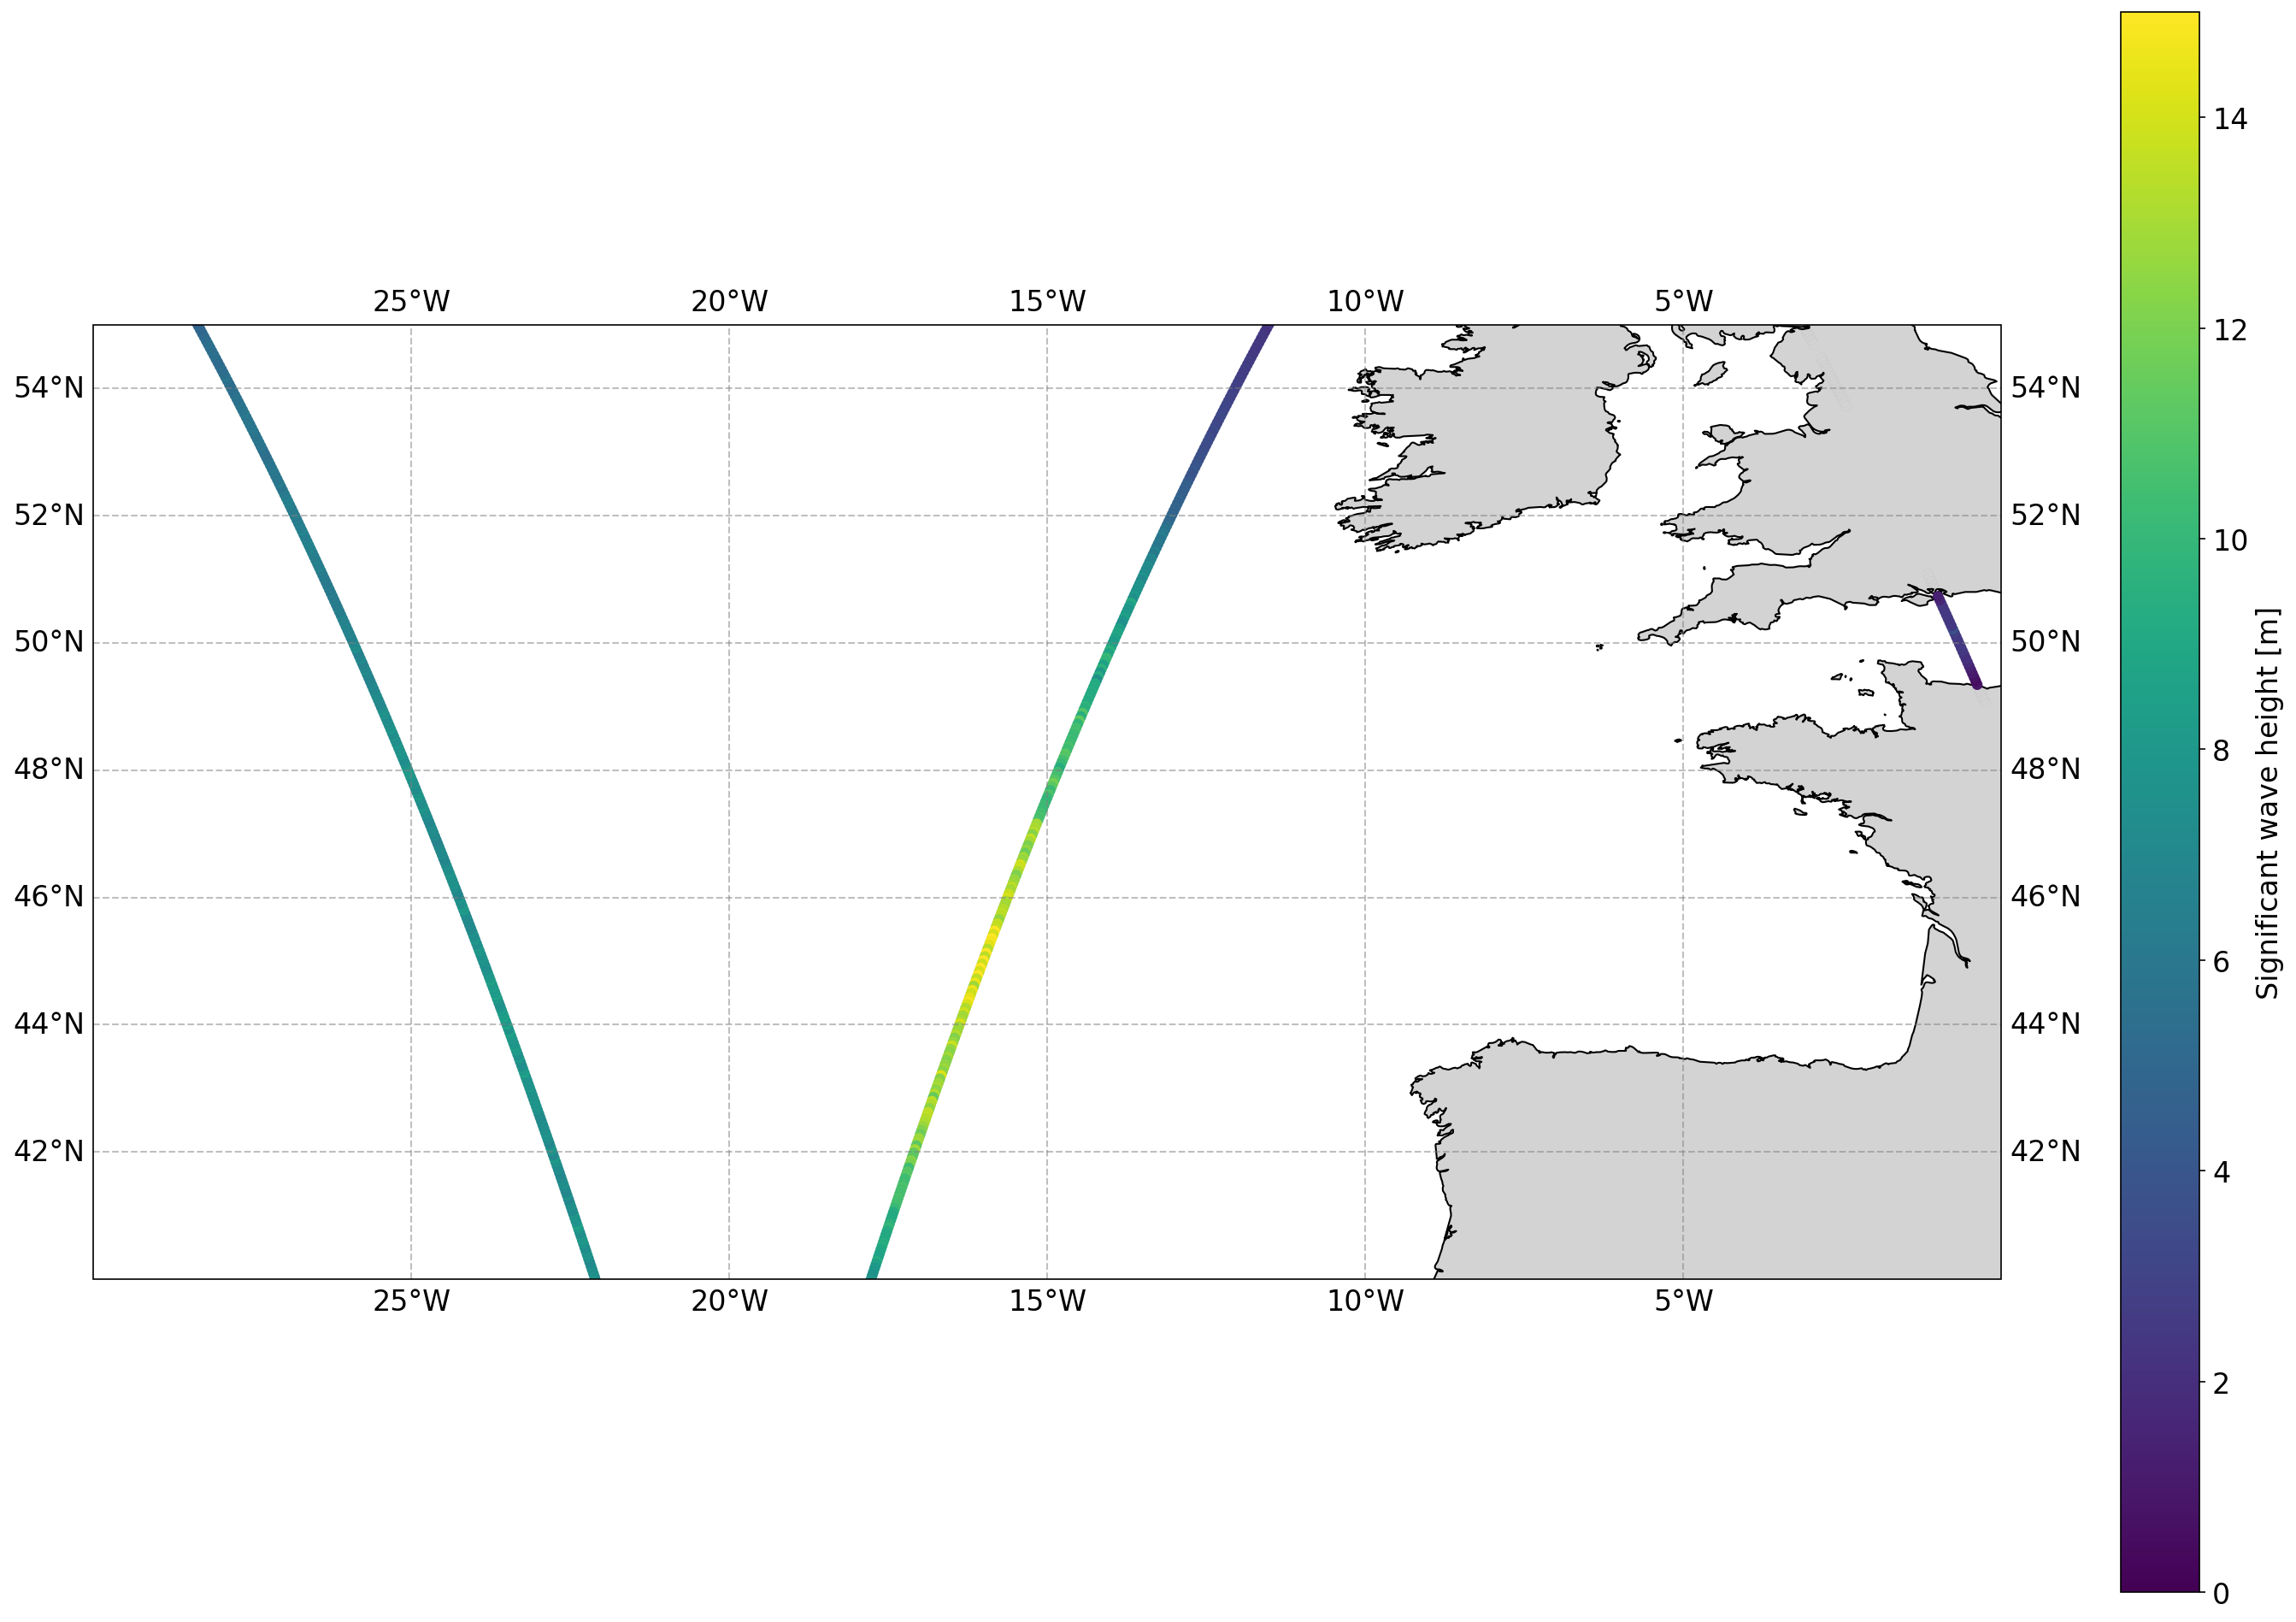

In [18]:
# make a figure
fig = plt.figure(figsize=(24,16), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

# decorate the figure
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)

# plot and show the data
tracks = ax.scatter(lon, lat, c=swh,  vmin=0, vmax=15, cmap='viridis',
                    marker='o', edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
cbar.set_label('Significant wave height [m]')
plt.show()

<div class="alert alert-info" role="alert">

## 3. <a id='section3'></a>looking at waveforms
[Back to top](#TOC-TOP)

</div>
 

We'll look at the waveforms corresponding to the high SWH area above (and compare with a much lower patch of wave heights) on the rightmost track


In [38]:
# select input file
input_file = os.path.join(download_dir, 'S3B_SR_2_WAT____20231104T112652_20231104T121252_20231130T031212_2760_086_023______MAR_O_NT_005.SEN3', 'enhanced_measurement.nc')

# open input file, select only the part we were looking at above, using this time the "20Hz" data since waveforms are only provided with this resolution
ncwf = xarray.open_dataset(input_file)
subsetncwf = ncwf.sel(time_20_ku=( (ncwf.lat_20_ku > lat_min ) & (ncwf.lat_20_ku < lat_max)))
ncwf.close()
subsetncwf

<xarray.Dataset> Size: 156MB
Dimensions:                                        (time_01: 2760,
                                                    time_20_ku: 5244,
                                                    time_20_c: 54169,
                                                    echo_sample_ind: 128)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 22kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 42kB ...
  * time_20_c                                      (time_20_c) datetime64[ns] 433kB ...
  * echo_sample_ind                                (echo_sample_ind) int8 128B ...
    lat_01                                         (time_01) float64 22kB ...
    lon_01                                         (time_01) float64 22kB ...
    lat_20_ku                                      (time_20_ku) float64 42kB ...
    lon_20_ku                                      (time_20_ku) float64 42kB ...
    lat_20_c                                       (time_20_c) float64 433kB ...
    lon_20_c                                       (time_20_c) float64 433kB ...
Data variables: (12/392)
    UTC_day_01                                     (time_01) datetime64[ns] 22kB ...
    UTC_sec_01                                     (time_01) float64 22kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 42kB ...
    UTC_sec_20_ku                                  (time_20_ku) float64 42kB ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 433kB ...
    UTC_sec_20_c                                   (time_20_c) float64 433kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 11kB ...
    num_20hz_meas_01_c                             (time_01) float32 11kB ...
    orbit_type_01                                  (time_01) float32 11kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 21kB ...
    iono_cor_alt_filtered_01_ku                    (time_01) float32 11kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float32 11kB ...
Attributes: (12/64)
    Conventions:                                 CF-1.6
    title:                                       IPF SRAL/MWR Level 2 Measure...
    mission_name:                                Sentinel 3B
    altimeter_sensor_name:                       SRAL
    radiometer_sensor_name:                      MWR
    gnss_sensor_name:                            GNSS
    ...                                          ...
    algo_bias_wind_speed_sig0_sar_ku_added:      -0.0008
    algo_bias_wind_speed_2p_sig0_sar_ku_added:   2.7735
    algo_bias_wind_speed_2p_swh_sar_ku_added:    0.0
    algo_bias_wind_speed_sig0_plrm_ku_added:     0.02795
    algo_bias_wind_speed_2p_sig0_plrm_ku_added:  2.8071
    algo_bias_wind_speed_2p_swh_plrm_ku_added:   0.0

Find the highest SWH values (we'll take the max, for an easier search)

max swh 20 Hz ku 19.799002
max swh 1 Hz ku 15.537001


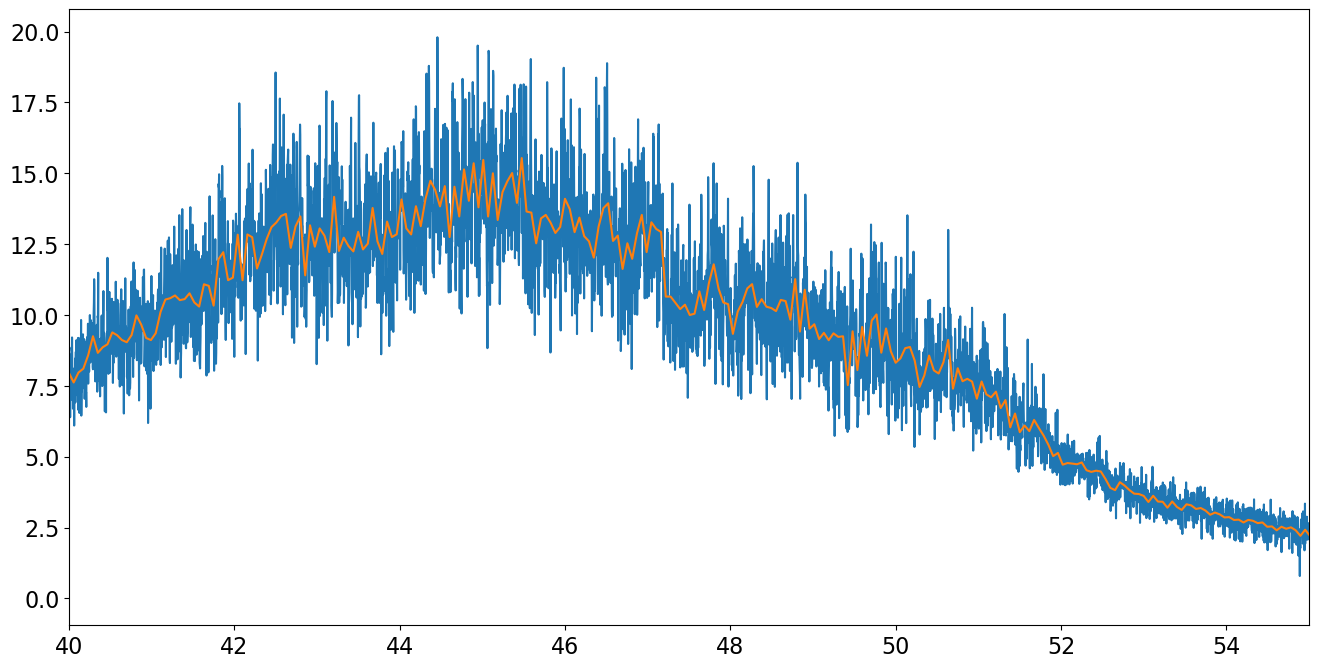

In [47]:
# read the variables
echo_sample_ind = subsetncwf['echo_sample_ind']
waveform_20_ku = subsetncwf['waveform_20_ku']
swh_ocean_20_ku = subsetncwf['swh_ocean_20_ku']
swh_ocean_01_ku = subsetncwf['swh_ocean_01_ku']
lat20 = subsetncwf['lat_20_ku']
lat1 = subsetncwf['lat_01']

# plot SWH at 20 Hz - note that those data are much noisier than 1 Hz ones (NB. 1Hz data have not been extracted over only part of the track)
print('max swh 20 Hz ku', np.max(swh_ocean_20_ku).values)
print('max swh 1 Hz ku', np.max(swh_ocean_01_ku).values)
fig = plt.figure(figsize=(16,8))
plt.xlim(lat_min,lat_max)
plt.plot(lat20,swh_ocean_20_ku)
plt.plot(lat1,swh_ocean_01_ku)

We'll plot the waveform at the max SWH at 20 Hz, to see what it is looking like -- it might not be the "real" highest SWH when looking at 1Hz data, but it will be among the highest SWHs of the storm

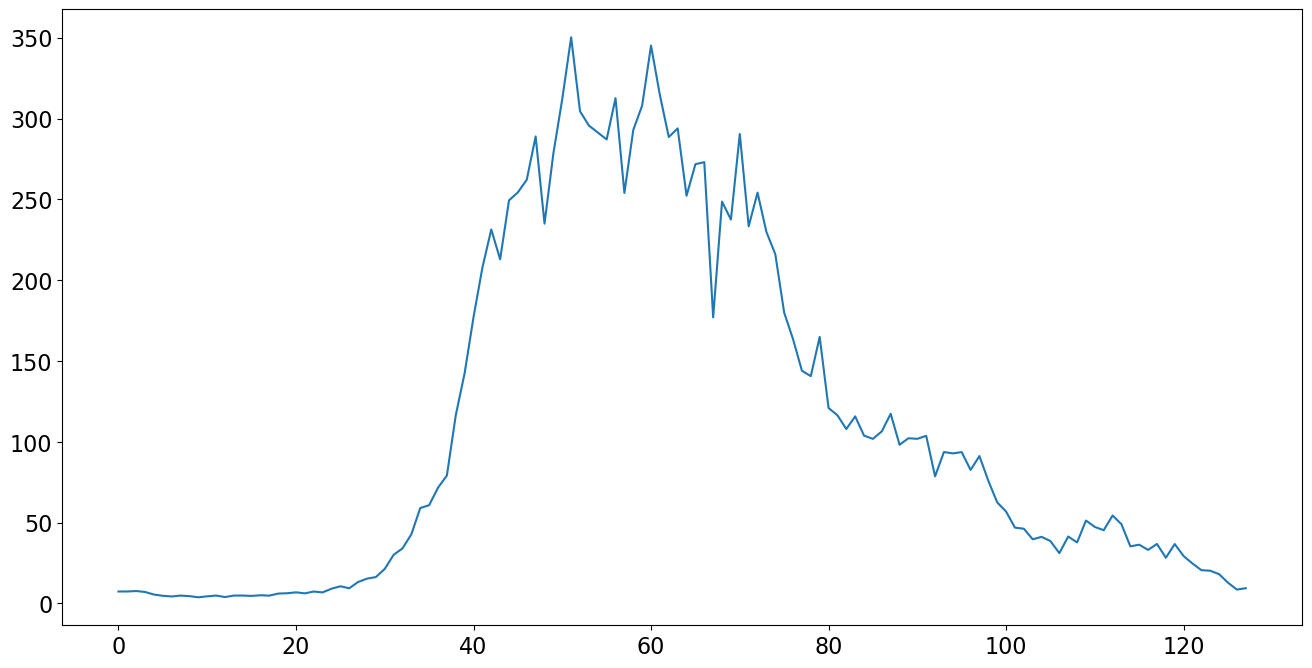

In [41]:
waveform_20_ku_max = waveform_20_ku.sel(time_20_ku=(swh_ocean_20_ku == np.max(swh_ocean_20_ku)))
wvf = waveform_20_ku_max[0,:]
fig = plt.figure(figsize=(16,8))
plt.plot(echo_sample_ind,wvf)

now, a low-SWH waveform, as comparison

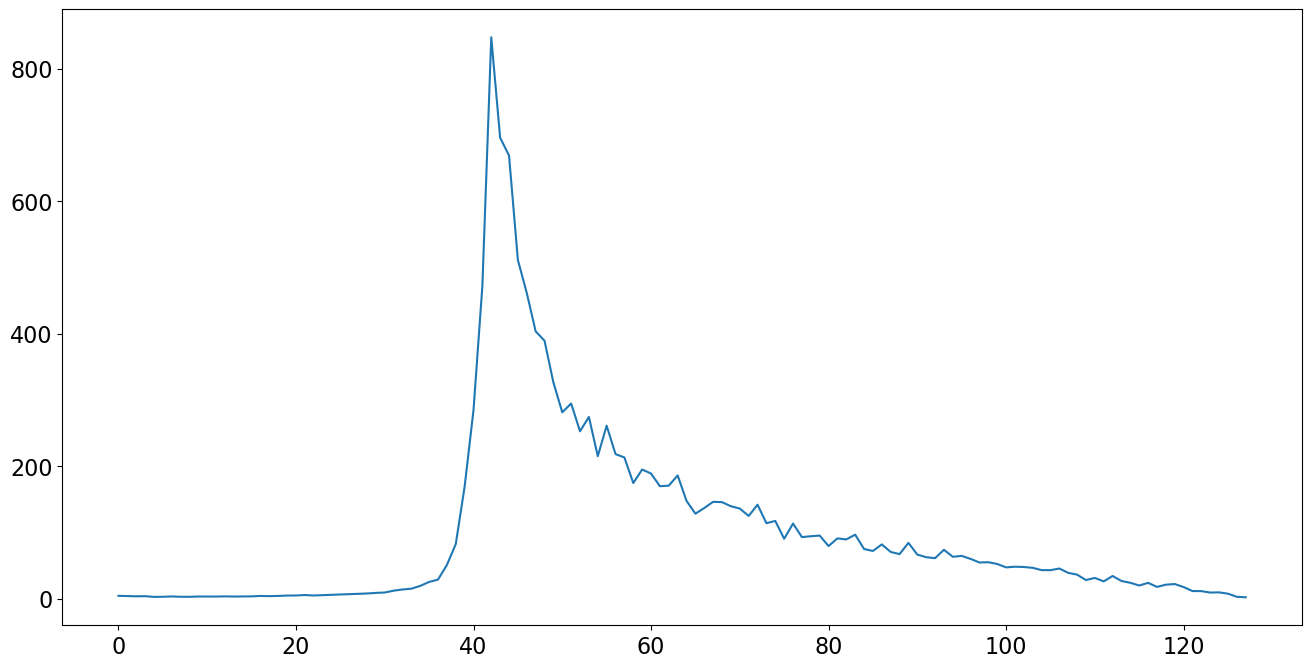

In [48]:
waveform_20_ku_min = waveform_20_ku.sel(time_20_ku=(swh_ocean_20_ku == np.min(swh_ocean_20_ku)))
wvf = waveform_20_ku_min[0,:]
fig = plt.figure(figsize=(16,8))
plt.plot(echo_sample_ind,wvf)

Note the difference between the two! The "low-SWH" waveform is close to theoretical shape (note that we are looking at data in SAR-mode, not Low-resolution ones). The SWH is computed from the slope of the leading edge - even if, in the "high SWH" case, the question is "where it is exactly". 

<hr>
<a href="../../../Index.ipynb" target="_blank"><< Index</a>
<hr>

<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>